<a href="https://colab.research.google.com/github/faithrts/COMP-551/blob/GaryBranch/A3_Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set-up

In [4]:
### importing libraries and setting the random seed

import numpy as np
import pandas as pd
import sys

%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#from matplotlib import cm

import re
import cv2
import math
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from keras.datasets import mnist
from importlib import reload
from typing import List
from tqdm import tqdm
from enum import Enum
from numpy.random import RandomState

from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

np.random.seed(1234)
random_state = RandomState(1234)

# a folder to store the saved graphs
!mkdir images

# Data Handling

### Helper functions

#### Loading and cleaning data

In [5]:
# assumes the last column of the dataframe is the labels
def x_y_from_df(df):
  x = df.iloc[:, :-1].to_numpy()
  y = df.iloc[:, -1].to_numpy()

  return x, y

In [6]:
def center_array(arr):
  mean = np.mean(arr)
  return_arr = np.array(arr) - mean
  # return_arr = [item - mean for item in arr]

  return return_arr

In [7]:
def normalize_array(arr):
  std = np.std(arr)
  return_arr = np.array(arr) / std
  # return_arr = [item / std for item in arr]

  return return_arr

In [8]:
def normalize_greyscale_array(arr):
  # the min and max pixel greyscale values
  min = 0
  max = 255

  return np.array(arr - min) / max - min

In [9]:
# pre-processes the df by performing mean subtraction and normalization
def preprocess_df(df):
  preprocessed_df = df.copy()

  for col in preprocessed_df.iloc[:, :-1]:
    preprocessed_col = normalize_array(center_array(df[col]))
    preprocessed_df[col] = preprocessed_col

  return preprocessed_df

In [10]:
def preprocess_greyscale_df(df):
  preprocessed_df = df.copy()

  for col in preprocessed_df.iloc[:, :-1]:
    preprocessed_col = normalize_greyscale_array(center_array(df[col]))
    preprocessed_df[col] = preprocessed_col

  return preprocessed_df

In [11]:
# pre-processes the df by performing mean subtraction
def preprocess_no_normalization_df(df):
  preprocessed_df = df.copy()

  for col in preprocessed_df.iloc[:, :-1]:
    preprocessed_col = center_array(df[col])
    preprocessed_df[col] = preprocessed_col

  return preprocessed_df

#### Plotting graphs

In [12]:
def plot_label_distributions(label_arr, dataset_name, labels = 0):
  
  # creates the plot
  plt.figure(figsize = (10,4))
  width = 0.6

  unique_labels = list(set(label_arr))
  counts = []

  for label in unique_labels:
    count = label_arr.count(label)
    counts.append(count)

  if labels == 0:
    labels = [str(label) for label in unique_labels]

  # the colour codes of the bars
  colours = ['#001219', '#005f73', '#0a9396', '#94d2bd', '#e9d8a6',
            '#ee9b00', '#ca6702', '#bb3e03', '#ae2012', '#9b2226']

  plt.bar(labels, counts, width, color = colours)
  plt.title("Distribution of Class Labels in " + dataset_name + " Dataset")
  plt.xlabel("Label")
  plt.ylabel("Count")

  for index, value in enumerate(counts):
    plt.text(index - 0.24, value + 5, str(round(value, 2)))

  plt.show()

## Importing

In [13]:
# clones the github repo
!git clone https://github.com/zalandoresearch/fashion-mnist
sys.path.insert(1, 'fashion-mnist/utils')

# imports the mnist reader from the repo
import mnist_reader

Cloning into 'fashion-mnist'...
remote: Enumerating objects: 762, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 762 (delta 0), reused 3 (delta 0), pack-reused 758
Receiving objects: 100% (762/762), 105.85 MiB | 43.71 MiB/s, done.
Resolving deltas: 100% (444/444), done.


### Loading and cleaning data

In [14]:
### loading the data using the github repo's mnist_reader.load_mnist

labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
          'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# training data
x_train_temp, y_train = mnist_reader.load_mnist('fashion-mnist/data/fashion', kind = 'train')

# testing data
x_test_temp, y_test = mnist_reader.load_mnist('fashion-mnist/data/fashion', kind = 't10k')

In [15]:
### creating dataframes to better understand data

# training dataframe
train_temp_df = pd.DataFrame(x_train_temp)
train_temp_df['LABEL'] = y_train

# testing dataframe
test_temp_df = pd.DataFrame(x_test_temp)
test_temp_df['LABEL'] = y_test

In [16]:
train_temp_df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,LABEL
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1,0,0,0,0,0,1,0,0,0,0,...,114,130,76,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,22,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,33,96,...,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
59996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
59997,0,0,0,0,0,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,3
59998,0,0,0,0,0,0,0,0,0,0,...,54,50,5,0,1,0,0,0,0,0


In [17]:
### centering and normalizing the data

# pre-processing each dataframe
train_df = preprocess_df(train_temp_df)
test_df = preprocess_df(test_temp_df)

# extracting arrays for x_train, y_train, x_test, y_test
x_train, y_train = x_y_from_df(train_df)
x_test, y_test = x_y_from_df(test_df)

In [18]:
### saving a copy of the un-preprocessed (centered and normalized) data

x_train_unprocessed, _ = x_y_from_df(train_temp_df)
x_test_unprocessed, _ = x_y_from_df(test_temp_df)

In [19]:
### saving a copy of the data normalized based on the pixel greyscale values

# pre-processing each dataframe
train_greyscale_df = preprocess_greyscale_df(train_temp_df)
test_greyscale_df = preprocess_greyscale_df(test_temp_df)

x_train_greyscale, y_train_greyscale = x_y_from_df(train_greyscale_df)
x_test_greyscale, y_test_greyscale = x_y_from_df(test_greyscale_df)

In [20]:
### saving a copy of the data reshaped into images for the convnet

# reshapes the arrays into image format (28 x 28 pixels)
x_train_convnet = np.reshape(x_train, (60000, 28, 28, 1))
x_test_convnet = np.reshape(x_test, (10000, 28, 28, 1))

y_train_convnet = tf.keras.utils.to_categorical(y_train)
y_test_convnet = tf.keras.utils.to_categorical(y_test)

In [21]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,LABEL
0,-0.008644,-0.023223,-0.039178,-0.041322,-0.057646,-0.071167,-0.098878,-0.156653,-0.239080,-0.377827,...,-0.474798,-0.394260,-0.406094,-0.441358,-0.396626,-0.288156,-0.156811,-0.089673,-0.034147,9
1,-0.008644,-0.023223,-0.039178,-0.041322,-0.057646,0.100437,-0.098878,-0.156653,-0.239080,-0.377827,...,1.857395,2.697741,1.324682,-0.441358,-0.396626,-0.288156,-0.156811,-0.089673,-0.034147,0
2,-0.008644,-0.023223,-0.039178,-0.041322,-0.057646,-0.071167,-0.098878,-0.156653,-0.239080,0.198023,...,-0.474798,-0.370475,-0.406094,-0.441358,-0.396626,-0.288156,-0.156811,-0.089673,-0.034147,0
3,-0.008644,-0.023223,-0.039178,-0.041322,-0.057646,-0.071167,-0.098878,-0.156653,1.145393,2.134974,...,-0.474798,-0.394260,-0.406094,-0.441358,-0.396626,-0.288156,-0.156811,-0.089673,-0.034147,3
4,-0.008644,-0.023223,-0.039178,-0.041322,-0.057646,-0.071167,-0.098878,-0.156653,-0.239080,-0.377827,...,-0.474798,-0.394260,-0.406094,-0.441358,-0.396626,-0.288156,-0.156811,-0.089673,-0.034147,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,-0.008644,-0.023223,-0.039178,-0.041322,-0.057646,-0.071167,-0.098878,-0.156653,-0.239080,-0.377827,...,-0.474798,-0.394260,-0.406094,-0.441358,-0.396626,-0.288156,-0.156811,-0.089673,-0.034147,5
59996,-0.008644,-0.023223,-0.039178,-0.041322,-0.057646,-0.071167,-0.098878,-0.156653,-0.239080,-0.377827,...,-0.474798,-0.394260,-0.406094,-0.441358,-0.396626,-0.288156,-0.156811,-0.089673,-0.034147,1
59997,-0.008644,-0.023223,-0.039178,-0.041322,-0.057646,-0.071167,-0.098878,-0.156653,-0.239080,-0.246952,...,-0.474798,-0.394260,-0.406094,-0.441358,-0.396626,-0.288156,-0.156811,-0.089673,-0.034147,3
59998,-0.008644,-0.023223,-0.039178,-0.041322,-0.057646,-0.071167,-0.098878,-0.156653,-0.239080,-0.377827,...,0.629925,0.794971,-0.292227,-0.441358,-0.374489,-0.288156,-0.156811,-0.089673,-0.034147,0


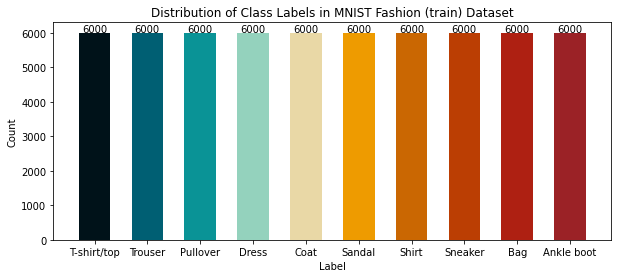

In [22]:
# plotting label distributions for training data
plot_label_distributions(train_df['LABEL'].tolist(), 'MNIST Fashion (train)', labels)

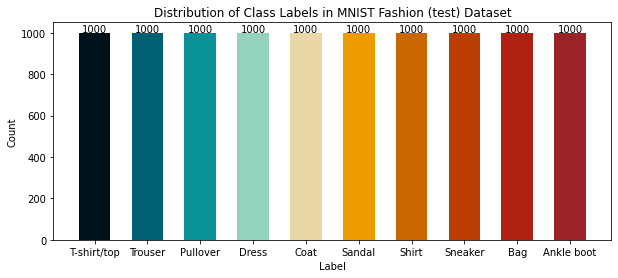

In [23]:
# plotting label distributions for testing data
plot_label_distributions(test_df['LABEL'].tolist(), 'MNIST Fashion (test)', labels)

# Implementing models

## Helper functions

## Layers

In [24]:
class NeuralNetLayer:
  def __init__(self):
    self.gradient = None
    self.parameters = None
        
  def forward(self, x):
    raise NotImplementedError

  def backward(self, gradient):
    raise NotImplementedError

In [25]:
class LinearLayer(NeuralNetLayer):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.ni = input_size
    self.no = output_size

    sigma = 0.1
    self.w = sigma * random_state.randn(output_size, input_size)
    self.b = sigma * random_state.randn(output_size)
    self.cur_input = None
    self.parameters = [self.w, self.b]

  # x is the data inputted into this layer during predictions;
  # unless this is the input layer, x is the original data inputted
  # into the model, but transformed by the preceding layers
  def forward(self, x):
    self.cur_input = x
    return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

  def backward(self, gradient):
    assert self.cur_input is not None, "Must call forward before backward"
    #dw = gradient.dot(self.cur_input)
    dw = gradient[:, :, None] @ self.cur_input[:, None, :]
    db = gradient
    self.gradient = [dw, db]
    return gradient.dot(self.w)

In [26]:
class ReLULayer(NeuralNetLayer):
  def __init__(self):
    super().__init__()
        
  def forward(self, x):
    self.gradient = np.where(x > 0, 1.0, 0.0)

    activated_x = np.maximum(0, x)
    return activated_x

  def backward(self, gradient):
    assert self.gradient is not None, "Must call forward before backward"
    return gradient * self.gradient

In [27]:
class LeakyReLULayer(NeuralNetLayer):
  def __init__(self):
    super().__init__()
        
  def forward(self, x):
    self.gradient = np.where(x > 0, 1.0, 0.01)

    # activated_x = [[float(element) if element > 0 else float(element) * 0.01 for element in sublist] for sublist in x]
    activated_x = np.maximum(0.01 * x, x)
    return activated_x

  def backward(self, gradient):
    assert self.gradient is not None, "Must call forward before backward"
    return gradient * self.gradient

In [28]:
class TanhLayer(NeuralNetLayer):
  def __init__(self):
    super().__init__()
        
  def forward(self, x):
    self.gradient = 1 - (np.tanh(x) ** 2)

    activated_x = np.tanh(x)
    return activated_x

  def backward(self, gradient):
    assert self.gradient is not None, "Must call forward before backward"
    return gradient * self.gradient

In [29]:
class SoftmaxOutputLayer(NeuralNetLayer):
  def __init__(self):
    super().__init__()
    self.cur_probs = None

  def forward(self, x):
    exps = np.exp(x)
    probs = exps / np.sum(exps, axis=-1)[:, None]
    #print(probs)
    self.cur_probs = probs
    return probs

  def backward(self, target):
    assert self.cur_probs is not None, "Must call forward before backward"
    return self.cur_probs - target

## MLP

In [30]:
class MLP:
  def __init__(self, n_features, n_output, hidden_layers = 0, hidden_units = [0], activation_func = "None"):
    layers_list = []

    # adds the input layer
    if hidden_layers == 0:
      layers_list.append(LinearLayer(n_features, n_output))
    else:
      layers_list.append(LinearLayer(n_features, hidden_units[0]))

    # adds the hidden layers
    for i in range(hidden_layers):

      # adds activation function layers
      if activation_func.upper() == "RELU":
        layers_list.append(ReLULayer())
      elif activation_func.upper() == "TANH":
        layers_list.append(TanhLayer())
      elif activation_func.upper() == "LEAKY RELU":
        layers_list.append(LeakyReLULayer())

      # if this is the last hidden layer, it outputs the output size
      if i == hidden_layers - 1:
        layers_list.append(LinearLayer(hidden_units[i], n_output))
        continue
          
      # if this is not the last hidden layer, it outputs the hidden size
      layers_list.append(LinearLayer(hidden_units[i], hidden_units[i + 1]))
          
    # adds the output layer
    layers_list.append(SoftmaxOutputLayer())

    self.layers = layers_list

  def forward(self, x):
    for layer in self.layers:
      x = layer.forward(x)
    return x

  def backward(self, target):
    for layer in self.layers[::-1]:
      target = layer.backward(target)

  def fit(self, x_train, y_train, x_test, y_test, opt, lambda_reg = 0, track_accuracy = False):    
    # one-hot encodes the labels
    labels_count = len(set(y_train))
    labels = np.eye(labels_count)[np.array(y_train)]

    loss = 0
    train_acc = 0
    test_acc = 0

    prediction_probs = self.forward(x_train)

    # back propagates
    self.backward(labels)
    opt.step()

    # calculates the loss
    loss = self.evaluate_loss(prediction_probs, labels, lambda_reg)

    ### calculates the training and testing accuracy
    if track_accuracy:
      # calculates the predicted labels using the current model weights
      train_pred = self.predict(x_train)
      test_pred = self.predict(x_test)

      # evaluates the training and testing accuracy
      train_acc = evaluate_acc(train_pred, y_train)
      test_acc = evaluate_acc(test_pred, y_test)

    # returns the CE loss, training accuracy, and testing accuracy
    return loss, train_acc, test_acc

  def fit_mini_batch(self, x_train, y_train, x_test, y_test, opt, batch_size, lambda_reg = 0, track_acc = False):    
    # one-hot encodes the labels
    labels_count = len(set(y_train))
    labels = np.eye(labels_count)[np.array(y_train)]

    x_train_size = len(x_train)

    # the number of instances in each batch
    batch_count = int(len(x_train) / batch_size)

    # the index at which the current batch starts (updated in the for loop)
    start_index = 0

    loss = 0
    train_acc = 0
    test_acc = 0

    # updating the model weights for each batch of training data
    for i in range(batch_count):

      # the index at which the current batch ends
      end_index = batch_size * (i + 1)
      if(i == batch_count - 1):
        # if this is the last batch, take all the training data from start_index to -1
        end_index = -1

      # isolates the current batch of training data and associated labels
      batch = x_train[start_index : end_index]
      batch_labels = labels[start_index : end_index]

      # updates the start index for the next batch (next iteration in the for loop)
      start_index = end_index

      # calculates the class predictions
      prediction_probs = self.forward(batch)

      # back propagates
      self.backward(batch_labels)
      opt.step(batch_size / x_train_size)

    # calculates the loss
    prediction_probs = self.forward(x_train)
    loss = self.evaluate_loss(prediction_probs, labels, lambda_reg)

    if track_acc:
      # calculates the training and testing accuracy
      train_pred = self.predict(x_train)
      test_pred = self.predict(x_test)
      
      train_acc = evaluate_acc(train_pred, y_train)
      test_acc = evaluate_acc(test_pred, y_test)

    # returns the CE loss, training accuracy, and testing accuracy
    return loss, train_acc, test_acc

  def fit_epoch_mini_batch(self, x_train, y_train, x_test, y_test, opt, batch_size, epochs, lambda_reg, track_acc):
    losses = []
    train_accs = []
    test_accs = []

    indices = np.arange(0, len(x_train))

    for epoch in range(epochs):
      random_state.shuffle(indices)
      x_train_shuf = x_train[indices]
      y_train_shuf = y_train[indices]

      loss, train_acc, test_acc = self.fit_mini_batch(x_train_shuf, y_train_shuf, x_test, y_test, opt, batch_size, lambda_reg, track_acc)

      # taking the last loss, training accuracy, and testing accuracy values
      losses.append(loss)
      train_accs.append(train_acc)
      test_accs.append(test_acc)
    
    return losses, train_accs, test_accs

  def evaluate_loss(self, prediction_probs, labels, lambda_reg):
    # adds regularization term (0 by default)
    reg_term = lambda_reg
    if lambda_reg != 0:
      weights_sum = 0

      # iterates through the layers in the model and adds the weights
      for layer in self.layers[::-1]:
        # if the layer is a LinearLayer, it has weights
        if type(layer).__name__ == "LinearLayer":
          weights_squared = layer.w ** 2
          weights_sum += sum(sum(weights_squared))

      reg_term = (lambda_reg * weights_sum)

    ### calculates the loss, adds it to the losses list, and back propagates based on the loss
    loss = -(labels * np.log(prediction_probs)).sum(axis=-1).mean() + reg_term

    return loss

  def evaluate_initial_metrics(self, x_train, x_test, y_train, y_test, lambda_reg):
    # evaluating the CE loss based on the predicted class probabilities
    labels_count = len(set(y_train))
    labels = np.eye(labels_count)[np.array(y_train)]
    prediction_probs = self.forward(x_train)
    loss = self.evaluate_loss(prediction_probs, labels, lambda_reg)

    # evaluates the training and testing classification accuracy
    train_pred = self.predict(x_train)
    test_pred = self.predict(x_test)
    train_acc = evaluate_acc(train_pred, y_train)
    test_acc = evaluate_acc(test_pred, y_test)

    return loss, train_acc, test_acc

  def predict(self, x):
    pred_prob = self.forward(x)
    predictions = np.argmax(pred_prob, axis = -1)
    return predictions

In [31]:
class Optimizer:
    def __init__(self, net: MLP):
        self.net = net

    # batch_coef is the number of instances in the batch / training data size
    def step(self, batch_coef):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient, batch_coef)

    def update(self, params, gradient):
        raise NotImplementedError

class GradientDescentOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float):
        super().__init__(net)
        self.lr = lr

    def update(self, params, gradient, batch_coef):
        for (p, g) in zip(params, gradient):
            p -= self.lr * g.mean(axis=0) * batch_coef

# Running experiments

### Helper functions

In [32]:
def evaluate_acc(true_labels, target_labels):
  # the number of labels
  label_count = true_labels.shape[0]

  # the accuracy is the number of correctly labelled instances divided
  # by the total number of instances
  accuracy = np.sum(target_labels == true_labels) / label_count

  return accuracy

In [33]:
def plot_losses(losses, hidden_layer_count, activation_func):
  x_axis = np.arange(1, len(losses) + 1, dtype = int)

  plt.figure(figsize=(8, 4))
  plt.plot(x_axis, losses)

  # changing the title based on whether there are hidden layers
  if hidden_layer_count == 0:
    plt.title("Cross-entropy training loss for " + str(hidden_layer_count) + " hidden layers")
  else:
    plt.title("Cross-entropy training loss for " + str(hidden_layer_count) + " hidden layer(s) with " + activation_func)
    
  plt.xlabel("Epoch")
  plt.xticks(x_axis, map(str, x_axis))
  plt.ylabel("Cross-entropy loss")

In [34]:
def plot_train_test_acc(train_accs, test_accs, hidden_layer_count, activation_func):
  x_axis = np.arange(1, len(train_accs) + 1, dtype = int)

  plt.figure(figsize=(8, 4))

  plt.plot(x_axis, train_accs, label = "Training accuracy")
  plt.plot(x_axis, test_accs, label = "Testing accuracy")

  # changing the title based on whether there are hidden layers
  if hidden_layer_count == 0:
    plt.title("Training and testing accuracy for " + str(hidden_layer_count) + " hidden layers")
  else:
    plt.title("Training and testing accuracy for " + str(hidden_layer_count) + " hidden layer(s) with " + activation_func)
    
  plt.xlabel("Epoch")
  plt.xticks(x_axis, map(str, x_axis))
  plt.ylabel("Classification accuracy")
  plt.legend()

In [35]:
def epoch_mini_batch(x_train, y_train, x_test, y_test, hidden_layers, hidden_units, activation_func, lr, batch_size, epochs, lambda_reg = 0, track_loss = False, track_acc = False):
  n_features = x_train.shape[-1]
  n_output = len(set(y_train))

  # creates the mlp and optimizer objects
  mlp = MLP(n_features, n_output, hidden_layers, hidden_units, activation_func)
  opt = GradientDescentOptimizer(mlp, lr)

  # saving the initial loss, training accuracy, and testing accuracy
  initial_loss, initial_train_acc, initial_test_acc = mlp.evaluate_initial_metrics(x_train, x_test, y_train, y_test, lambda_reg)

  # training the model using mini-batch times epochs
  losses, train_accs, test_accs = mlp.fit_epoch_mini_batch(x_train, y_train, x_test, y_test, opt, batch_size, epochs, lambda_reg, track_acc)

  #losses.insert(0, initial_loss)

  # the number of hidden layers
  hidden_layer_count = int((len(mlp.layers) - 2) / 2)

  # plots the cross-entropy loss
  if track_loss:
    plot_losses(losses, hidden_layer_count, activation_func)
    
  # plots the training and testing accuracy
  if track_acc:
    plot_train_test_acc(train_accs, test_accs, hidden_layer_count, activation_func)

  return mlp

In [36]:
def evaluate_mlp_acc(mlp: MLP, x_train, y_train, x_test, y_test, silent = True):
  train_predictions = mlp.predict(x_train)
  test_predictions = mlp.predict(x_test)
  
  train_acc = evaluate_acc(train_predictions, y_train)
  test_acc = evaluate_acc(test_predictions, y_test)
  
  if not silent:
    print("The accuracy of the model on the training data: " + str(round((train_acc * 100), 2)) + "%")
    print("The accuracy of the model on the testing data: " + str(round((test_acc * 100), 2)) + "%")
    print("\n")

  return train_acc, test_acc
                     

## MLP

### Baseline accuracy tests



In [37]:
### plotting training and testing for 0 hidden layers (ReLU)

mlp0_test = epoch_mini_batch(x_train, y_train, x_test, y_test, 0, [], "ReLU", 0.1, 1000, 20, track_acc = True)
acc0_test = evaluate_mlp_acc(mlp0_test, x_train, y_train, x_test, y_test, silent = False)

KeyboardInterrupt: ignored

In [ ]:
### plotting loss for 0 hidden layers (ReLU)

mlp0 = epoch_mini_batch(x_train, y_train, x_test, y_test, 0, [], "ReLU", 0.1, 1000, 20, track_loss = True)
acc0 = evaluate_mlp_acc(mlp0, x_train, y_train, x_test, y_test, silent = False)

In [ ]:
### plotting training and testing accuracy for 1 hidden layer (ReLU)

mlp1_test = epoch_mini_batch(x_train, y_train, x_test, y_test, 1, [128], "ReLU", 0.1, 1000, 20, track_acc = True)
acc1_test = evaluate_mlp_acc(mlp1_test, x_train, y_train, x_test, y_test, silent = False)

In [ ]:
### plotting loss for 1 hidden layer (ReLU)

mlp1 = epoch_mini_batch(x_train, y_train, x_test, y_test, 1, [128], "ReLU", 0.1, 1000, 20, track_loss = True)
acc1 = evaluate_mlp_acc(mlp1, x_train, y_train, x_test, y_test, silent = False)

In [ ]:
### plotting training and testing accuracy for 2 hidden layers (ReLU)

mlp2_test = epoch_mini_batch(x_train, y_train, x_test, y_test, 2, [128, 128], "ReLU", 0.1, 1000, 20, track_acc = True)
acc2_test = evaluate_mlp_acc(mlp2_test, x_train, y_train, x_test, y_test, silent = False)

In [ ]:
### plotting loss for 2 hidden layers (ReLU)

mlp2 = epoch_mini_batch(x_train, y_train, x_test, y_test, 1, [128], "ReLU", 0.1, 1000, 20, track_loss = True)
acc2 = evaluate_mlp_acc(mlp2, x_train, y_train, x_test, y_test, silent = False)

### Testing activation functions other than ReLU

In [ ]:
### training and testing 2 hidden layers with Tanh activation functions

mlp2t = epoch_mini_batch(x_train, y_train, x_test, y_test, 2, [128, 128], "Tanh", 0.1, 1000, 20, track_loss = True)
acc2t = evaluate_mlp_acc(mlp2t, x_train, y_train, x_test, y_test, silent = False)

In [ ]:
### training and testing 2 hidden layers with leaky ReLU activation functions

mlp2l = epoch_mini_batch(x_train, y_train, x_test, y_test, 2, [128, 128], "Leaky ReLU", 0.1, 1000, 20, track_loss = True)
acc2l = evaluate_mlp_acc(mlp2l, x_train, y_train, x_test, y_test, silent = False)

### Adding L2 regularization

In [ ]:
### training and testing 2 hidden layers with ReLU activation functions and L2 regularization

mlp2reg = epoch_mini_batch(x_train, y_train, x_test, y_test, 2, [128, 128], "ReLU", 0.1, 1000, 20, track_loss = True, lambda_reg = 0.001)
acc2reg = evaluate_mlp_acc(mlp2reg, x_train, y_train, x_test, y_test, silent = False)

### Using a model trained on unnormalized images

In [ ]:
### training and testing 2 hidden layers with ReLu activation functions

### faith - will fix this

mlp2ln = epoch_mini_batch(x_train_unprocessed, y_train, x_test_unprocessed, y_test, 2, [128, 128], "ReLU", 0.1, 1000, 5, track_loss = True)
acc2ln = evaluate_mlp_acc(mlp2ln, x_train_unprocessed, y_train, x_test_unprocessed, y_test, silent = False)

## Convnet

### Temp (Gary make functions for the code below pls)

In [110]:
def convnetModel(optimizer, num_filters = 8, filter_size = 3, strides = 1, padding = 'valid', activation = 'relu', epochs = 3, batch_size = 60):
  model = models.Sequential()
  #we add 2 layers as mentionned in the pdf
  #these 2 layers are the conv layers
  #input shape is 3d because thats how keras library wants it
  model.add(layers.Conv2D(filters = num_filters, kernel_size = filter_size, strides = strides,
                         padding = padding, activation = activation, input_shape=(28,28,1)))
  model.add(layers.Conv2D(filters = num_filters, kernel_size = filter_size, strides = strides,
                         padding = padding, activation = activation))
  
  model.add(layers.Flatten())     #?input_shape=(28,28) is added by Gary

  #what is this part?
  #the first two layers are the fully connected layer, the number of hidden units is specified in the doc
  #the last layer is to check how accurate the prediction is?
  model.add(layers.Dense(128, activation = activation))
  model.add(layers.Dense(128, activation = activation))
  model.add(layers.Dense(10, activation = 'softmax'))      
  #model.summary()
  model.compile(optimizer=optimizer,
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

  ### fitting the model
  history = model.fit(
    x = x_train_convnet,         
    y = y_train_convnet,        
    epochs=epochs,                # number of training epochs
    batch_size=batch_size,
    verbose = 0,
    validation_data = (x_test_convnet, y_test_convnet)
  ) 

  cnn_train_acc = history.history['accuracy']
  cnn_train_loss = history.history['loss']
  cnn_test_acc = history.history['val_accuracy']
  cnn_test_loss = history.history['val_loss']

  cnn_train_last_acc = history.history['accuracy'][-1]
  cnn_test_last_acc = history.history['val_accuracy'][-1]

  print("The accuracy of the model on the training data: " + str(round((cnn_train_last_acc * 100), 2)) + "%")
  print("The accuracy of the model on the testing data: " + str(round((cnn_test_last_acc * 100), 2)) + "%")
  print("\n")

  # Overall accuracy
  #cnn_test_loss, cnn_test_acc = model.evaluate(x_test_squeezed, y_test)
  #print("Test accuracy:", cnn_test_acc)

  #predictions = model.predict(y_test)
  #print(np.shape(predictions))

  #ndx = find_interesting_test_images(predictions, test_labels)
  #plot_interesting_test_results(test_images, test_labels, predictions, class_names, ndx)

  
  plot_train_test_acc(cnn_train_acc, cnn_test_acc, 2, "ReLU")
  plot_losses(cnn_train_loss, 2, "ReLU")


The accuracy of the model on the training data: 97.5%
The accuracy of the model on the testing data: 90.04%




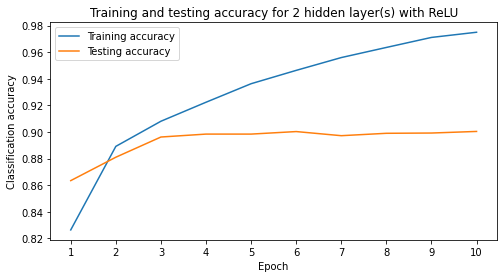

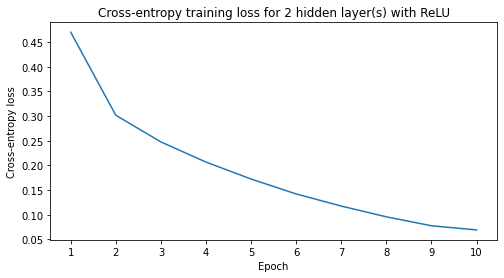

In [112]:
optimizer = optimizers.SGD(lr=0.1, decay=0, momentum=0, nesterov=False)
convnetModel(optimizer, num_filters = 8, filter_size = 3, strides = 1, padding = 'valid', activation = 'relu', epochs = 10, batch_size = 60)
